In [1]:
import pickle

import numpy as np
import pandas as pd

from torch import Tensor
import torch.nn.functional as F

from transformers import AutoTokenizer, AutoModel
from transformers import pipeline
from transformers import T5ForConditionalGeneration, AutoTokenizer
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch

from pypdf import PdfReader

# PDF QA

#### The plan! 🤔

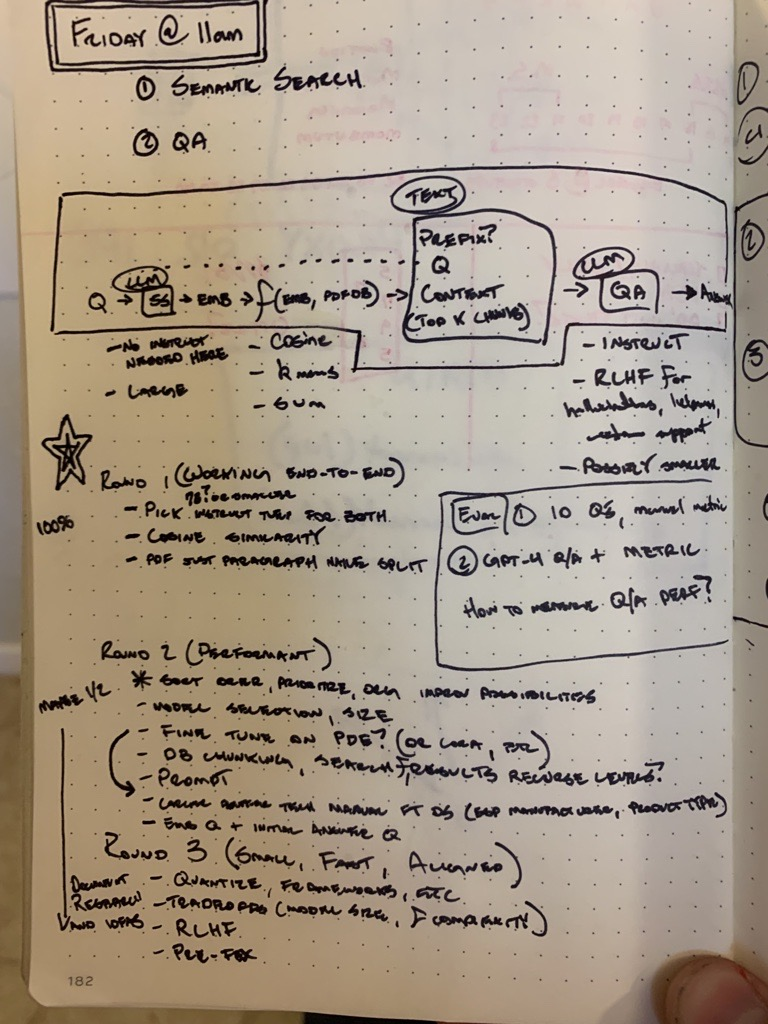

#### Currrent setup

pypdf to extract text, chunk naively by pages (exclude toc, index)

SS Model - [intfloat/e5-large](https://huggingface.co/intfloat/e5-large)
- [Sentence Transformers Model Overview](https://www.sbert.net/docs/pretrained_models.html#model-overview)
- [HF MTEB Leaderboard](https://huggingface.co/spaces/mteb/leaderboard)

Retrieve cosine distance for top 2 page results grab page and next page and join as context

QA Model - [flan-ul2](https://huggingface.co/google/flan-ul2)

Prompt: f"context:\n {context} {prefix}: \n{question}\n." where context is the retrieved context, question is the user query, and prefix is "Answer the following question by reasoning step by step."

Long max length set, 1024.

### PDF Text Extraction 

In [2]:
# reader = PdfReader("/home/davidwagner/manual.pdf")

In [3]:
# %%time # 38s
# pages = [page.extract_text() for page in reader.pages]

In [4]:
# with open("pages.pkl", "wb") as f:
#     pickle.dump(pages, f)

In [5]:
with open("pages.pkl", "rb") as f:
    pages = pickle.load(f)

In [6]:
len(pages)

540

### Semantic Search Model

In [7]:
%%time
def average_pool(last_hidden_states: Tensor, attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]
# Each input text should start with "query: " or "passage: ".
ss_tokenizer = AutoTokenizer.from_pretrained('intfloat/e5-large')
ss_model = AutoModel.from_pretrained('intfloat/e5-large')

CPU times: user 3.39 s, sys: 1.88 s, total: 5.27 s
Wall time: 7.92 s


In [8]:
ss_model.to("cuda");

### Create Semantic Search Database

In [9]:
# eliminate these pages from search for now, large token count and high frequency in sem search results
# toc, figures: 3 - 13
# index: 531 - 538
for i in range(2, 13):
    pages[i] = " "
for i in range(530, 538):
    pages[i] = " "

In [10]:
%%time
db = []
for i, page in enumerate(pages):
    # input_texts = [f"passage: {p}" for p in pages][:50]
    input_texts = [f"passage: {page}"]
    batch_dict = ss_tokenizer(input_texts, max_length=512, padding=True, truncation=True, return_tensors='pt')
    batch_dict.to("cuda")
    outputs = ss_model(**batch_dict)
    embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
    embeddings = F.normalize(embeddings, p=2, dim=1)
    db.append(embeddings.detach().cpu())

CPU times: user 15.7 s, sys: 457 ms, total: 16.1 s
Wall time: 17.7 s


In [11]:
%%time
db = torch.concat(db)
db.shape

CPU times: user 4.08 ms, sys: 857 µs, total: 4.94 ms
Wall time: 6.3 ms


torch.Size([540, 1024])

# Query DB

In [12]:
def retrieve_context(query):
    input_texts = [f"query: {query}"]
    batch_dict = ss_tokenizer(input_texts, max_length=512, padding=True, truncation=True, return_tensors='pt')
    batch_dict.to("cuda")
    outputs = ss_model(**batch_dict)
    query_embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
    query_embeddings = F.normalize(query_embeddings, p=2, dim=1)
    query_embeddings = query_embeddings.detach().cpu()
    scores = (query_embeddings @ db.T) * 100
    first, second = scores.topk(2).indices[0].tolist()
    # top_idx = scores.argmax().item()
    first_context = "\n".join(pages[first: first + 2])
    second_context = "\n".join(pages[second: second + 2])
    top_pages = "\n".join([first_context, second_context])
    return top_pages, [first, second], query_embeddings, scores

In [13]:
query = "What are the required tools?"
top_pages, top_two, query_embeddings, scores = retrieve_context(query)

array([[<Axes: title={'center': '0'}>]], dtype=object)

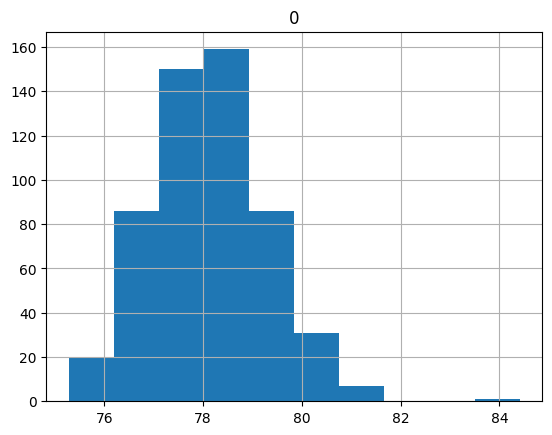

In [14]:
pd.DataFrame(scores.tolist()[0]).hist()

In [15]:
top_two

[28, 468]

In [16]:
scores.argmax()

tensor(28)

In [17]:
scores[0, 28]

tensor(84.4103)

### QA Model

In [18]:
%%time
model = T5ForConditionalGeneration.from_pretrained("google/flan-ul2", device_map="auto", load_in_8bit=True)                                                                 
tokenizer = AutoTokenizer.from_pretrained("google/flan-ul2")

Overriding torch_dtype=None with `torch_dtype=torch.float16` due to requirements of `bitsandbytes` to enable model loading in mixed int8. Either pass torch_dtype=torch.float16 or don't pass this argument at all to remove this warning.



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /home/davidwagner/mambaforge/envs/dev/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda117.so
CUDA SETUP: CUDA runtime path found: /home/davidwagner/mambaforge/envs/dev/lib/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 117
CUDA SETUP: Loading binary /home/davidwagner/mambaforge/envs/dev/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda117.so...


/home/davidwagner/mambaforge/envs/dev/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: Found duplicate ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] files: {PosixPath('/home/davidwagner/mambaforge/envs/dev/lib/libcudart.so.11.0'), PosixPath('/home/davidwagner/mambaforge/envs/dev/lib/libcudart.so')}.. We'll flip a coin and try one of these, in order to fail forward.
Either way, this might cause trouble in the future:
If you get `CUDA error: invalid device function` errors, the above might be the cause and the solution is to make sure only one ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] in the paths that we search based on your env.
  warn(msg)


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 1min 59s, sys: 1min 1s, total: 3min
Wall time: 2min 40s


In [19]:
question = "Where can I find more information?"
# context = reader.pages[18].extract_text()
context, page_num, _, scores = retrieve_context(question)
page_num

[18, 363]

In [20]:
# model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-xxl")
# tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-xxl", device_map="auto")

In [21]:
%%time
inputs = tokenizer(f"question: {question} context: {context}", return_tensors="pt")
print(inputs.input_ids.shape)
outputs = model.generate(**inputs)
print(tokenizer.batch_decode(outputs, skip_special_tokens=True))

torch.Size([1, 1149])


/home/davidwagner/mambaforge/envs/dev/lib/python3.10/site-packages/transformers/generation/utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/home/davidwagner/mambaforge/envs/dev/lib/python3.10/site-packages/transformers/generation/utils.py:1374: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


['Self Checkout System 6 MT4888 Hardware Service Guide Models Exx and BW']
CPU times: user 10.4 s, sys: 585 ms, total: 11 s
Wall time: 10.3 s


In [22]:
def query(question):
    context, page_num, _, scores = retrieve_context(question)
    prefix = "Answer the following question by reasoning step by step."
    inputs = tokenizer(f"context:\n {context} {prefix}: \n{question}\n.", return_tensors="pt").input_ids.to("cuda")
    print("Tokens: ", inputs.shape, "\n")
    outputs = model.generate(inputs, max_length=256, temperature=0.3)
    answer = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    text = ""
    for line in answer[0].split(". "):
        text += line
        text += '\n'
    return text, context

In [23]:
txt, _ = query("Where can I find more information?")

Tokens:  torch.Size([1, 1160]) 



In [24]:
print(txt)

Current versions of Toshiba publications are available on the Toshiba Global Commerce Solutions website at http://www.toshibacommerce.com/support/publications
Therefore, the final answer is Current versions of Toshiba publications are available on the Toshiba Global Commerce Solutions website at http :// www.toshibacommerce.com / support / publications.



In [56]:
query("What tools should I use?")

Tokens:  torch.Size([1, 1482]) 

Bill dispenser screwdriver kit (PN 41K6284) Cash models with bill dispenser 5/16-inch (8 mm) socket All 10 mm socket All Torx T-10 screwdriver - 9-3/4 inch long All 1.5 mm to 10 mm ball-end hex key set (PN 73G5473) All 5.5 mm driver All Test currency (25 each of $1, $5, and $20); US and Euro currency onlyCash models with bill dispenser (not for use in models with Banknote recycler) 5 mm hex socket drive and 6mm hex socket drives All models except E01 and E11

Therefore, the final answer is Bill dispenser screwdriver kit ( PN 41K6284 ) Cash models with bill dispenser 5/16 - inch (8 mm ) socket All 10 mm socket All Torx T-10 screwdriver - 9-3 / 4 inch long All 1.5 mm to 10 mm ball - end hex key set ( PN 73G5473 ) All 5.5 mm driver All Test currency ( 25 each of $1, $5, and $20 ) ; US and Euro currency only Cash models with bill dispenser ( not for use in models with Banknote recycler ) 5 mm hex socket drive and 6mm hex socket drives All models except E01 

Clearing a jam p. 53

In [57]:
query("What chapter, section and/or page number talks about fixing a jam in the bundler?")

Tokens:  torch.Size([1, 1249]) 

Clearing a jam from the bundler is on page 54 of the 4888 Hardware Service Guide

Therefore, the final answer is Chapter 4.



Good overview figure on 32.

In [58]:
query("Is there a figure include that presents an overview of where all the parts are? What page is it on?")

Tokens:  torch.Size([1, 357]) 

Figure 7 presents an overview of where all the parts are

It is on page 31

Therefore, the final answer is 31.



This should be 70-120lbs and 3 people (p. 740)

In [62]:
query("How much does the security conveyor weigh and how many people would it take to lift safely?")

Tokens:  torch.Size([1, 1866]) 

The conveyor weighs 60 lb and it would take 2 people to lift it safely

Therefore, the final answer is 2.



Technically I was looking for figure 391, but 392 a couple pages down is the same figure. 

In [64]:
query("What page has a diagram of all the connections on the back of this computer?")

Tokens:  torch.Size([1, 935]) 

Lane PC Connectors (4900-785) Figure 392 shows the connectors on the rear of the lane PC

Therefore, the final answer is Figure 392.



First part is odd, but bottom of 329 is correct.

In [73]:
ctx = query("What page explains installation of the coin recyler?")

Tokens:  torch.Size([1, 812]) 

The relevant information to answer the above question is: 3

Connect the cables to the connectors on the interface card in the rear corder of the recycler

Therefore, the final answer is 329.



In [25]:
%%time
txt, ctx = query("How do I install the coin recycler?")

Tokens:  torch.Size([1, 881]) 

CPU times: user 26.1 s, sys: 50.6 ms, total: 26.2 s
Wall time: 25.2 s


In [26]:
print(txt)

Install the carousel onto the recycling coin handler frame
a
Position the carousel with the two mounting holes in the top corners closest to you
b
Align the mounting holes on the top of the carousel with the two threaded mounting studs
c
Set the carousel in place and install the nuts on the two threaded studs
d
Install the two mounting screws on the back of the recycling coin handlers frame
Therefore, the final answer is Install the carousel onto the recycling coin handler frame.



In [28]:
print(ctx)

AFigure 297. Remove the two nuts from the front edge of the recycling coin handler (top view)
5. Remove the two nuts from the front corners of the carousel and set them aside for future
use.
6. Route the interface cable and its connector through the opening in the right rear corner of
the carousel.
7. Lift the carousel up and off the recyclers frame.
Installing the carousel
Complete the following procedure to install the carousel in the recycling coin handler.
1. Install the carousel onto the recycling coin handler frame.
a. Position the carousel with the two mounting holes in the top corners closest to you.
b. Align the mounting holes on the top of the carousel with the two threaded mounting
studs.
c. Set the carousel in place and install the nuts on the two threaded studs.
d. Install the two mounting screws on the back of the recycling coin handlers frame.
2. Install the carousel motor (see “Install the carousel motor” on page 351 ).
3. Install the main controller board and opto sens

In [37]:
%%time
txt2, ctx2 = query("How do I install the coin recycler?")

Tokens:  torch.Size([1, 881]) 

CPU times: user 26.4 s, sys: 20.8 ms, total: 26.4 s
Wall time: 25.4 s


In [38]:
print(txt2)

Install the carousel onto the recycling coin handler frame
a
Position the carousel with the two mounting holes in the top corners closest to you
b
Align the mounting holes on the top of the carousel with the two threaded mounting studs
c
Set the carousel in place and install the nuts on the two threaded studs
d
Install the two mounting screws on the back of the recycling coin handlers frame
Therefore, the final answer is Install the carousel onto the recycling coin handler frame.



# Max page length and context 

In [43]:
%%time
pages_tokenized = [ss_tokenizer(page, return_tensors="pt") for page in pages]

Token indices sequence length is longer than the specified maximum sequence length for this model (524 > 512). Running this sequence through the model will result in indexing errors


CPU times: user 497 ms, sys: 0 ns, total: 497 ms
Wall time: 494 ms


Check the distribution of number of tokens per page in the manual.

array([[<Axes: title={'center': '0'}>]], dtype=object)

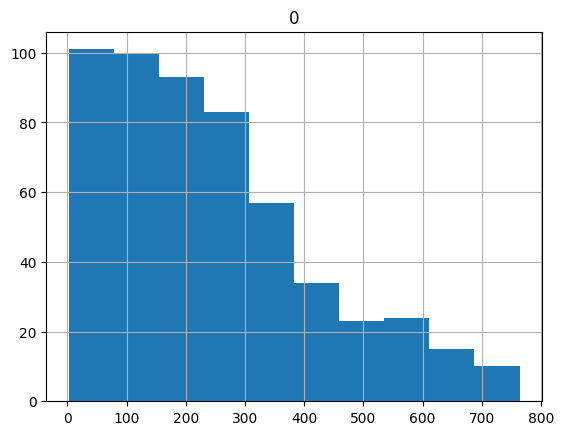

In [44]:
pd.DataFrame([p['input_ids'].shape[1] for p in pages_tokenized]).hist()

In [45]:
pages_sorted = sorted(pages, key=len, reverse=True)

In [46]:
question = "Looks like our carousel frame is broken, what steps should I take to fix it?"
context = "\n".join(pages[97:99])

In [47]:
%%time
# inputs = tokenizer(f"question: \n{question}\n context:\n {context}", return_tensors="pt").input_ids.to("cuda")
prefix = "Answer the following question by reasoning step by step."
inputs = tokenizer(f"context:\n {context} {prefix}: \n{question}\n.", return_tensors="pt").input_ids.to("cuda")
print(inputs.shape)
outputs = model.generate(inputs, max_length=1024)
answer = tokenizer.batch_decode(outputs, skip_special_tokens=True)

torch.Size([1, 1635])
CPU times: user 2min 28s, sys: 20.5 ms, total: 2min 28s
Wall time: 2min 29s


In [48]:
for line in answer[0].split(". "):
    print(line)
    print()

To fix the carousel frame, you should remove the scale platter (see Chapter 11, Component removal and installation procedures: 6-bag carousel bagging units on page 401 )

Begin the process of removing the complete carousel load cell system; stop before the load cell unit is removed from the carousel

The load cell system must remain in the carousel because this procedure verifies whether the load cell frame is introducing tension into the load cell system

Tension in the load cell system causes load cells to report weights incorrectly

After the load cell frame mounting bolts have been removed, verify that the load cell cross- frame does not rock or seesaw between two mounting points

If the load cell frame does rock or seesaw, then the base of the load cell frame is not inducing tension in the system

Reinstall and retighten the mounting bolts in a crisscross pattern and then go to step 6 on page 99

• If the load cell frame does rock or seesaw, go to step 4 on page 99

4

If the load

# Time

In [104]:
%%time
inputs = tokenizer(f"What are the steps involved in fine tuning a large language model?", return_tensors="pt").input_ids.to("cuda")
print("Tokens: ", inputs.shape, "\n")

Tokens:  torch.Size([1, 15]) 

CPU times: user 3.03 ms, sys: 284 µs, total: 3.31 ms
Wall time: 2.29 ms


In [105]:
# n = 2000
# inputs = torch.randint(0, tokenizer.vocab_size, size=(1, n)).to("cuda")

In [125]:
%%time
# outputs = model.generate(inputs, top_k=0, do_sample=True, max_length=512, temperature=0.7)
outputs = model.generate(inputs, max_length=512)

CPU times: user 2.09 s, sys: 0 ns, total: 2.09 s
Wall time: 2.09 s


In [126]:
%%time
answer = tokenizer.batch_decode(outputs, skip_special_tokens=True)

CPU times: user 1.24 ms, sys: 0 ns, total: 1.24 ms
Wall time: 876 µs


In [127]:
answer

['Identify the best model for the data.']